In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
import plotly.graph_objs as go
from fbprophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric,add_changepoints_to_plot,set_y_as_percent
from fbprophet.diagnostics import rmse, performance_metrics, cross_validation

df = pd.read_csv('divvy_daily.csv')
df = df[['date', 'rides']]
df['date'] = pd.to_datetime(df['date'])
df.columns = ['ds', 'y']

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1458 non-null   datetime64[ns]
 1   y       1458 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 22.9 KB


In [22]:
df.describe()

,y
count,1458.000000
mean,6512.506859
std,3951.680072
min,1.000000
25%,3183.250000
50%,6169.000000
75%,9289.250000
max,16095.000000


In [5]:
df

,ds,y
0,2014-01-01,95
1,2014-01-02,111
2,2014-01-03,6
3,2014-01-04,181
4,2014-01-05,32
...,...,...
1453,2017-12-27,1117
1454,2017-12-28,1267
1455,2017-12-29,1049
1456,2017-12-30,519


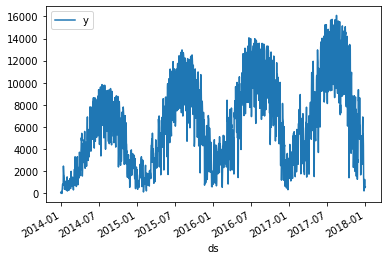

In [8]:
df_1 = df.set_index('ds')
df_1.index = pd.to_datetime(df_1.index)
df_1.plot()

##The main parameters for Prophet models are:

1. growth: The form of the trend: "linear", or "logistic".
2. changepoint_num: The maximum number of trend changepoints allowed when modeling the trend
3. changepoint_range: The range affects how close the changepoints can go to the end of the time series. The larger the value, the more flexible the trend.

##Yearly, Weekly, and Daily Seasonality:

1. Yearly: seasonality_yearly - Useful when seasonal patterns appear year-over-year

2. Weekly: seasonality_weekly - Useful when seasonal patterns appear week-over-week (e.g. daily data)
3. Daily: seasonality_daily - Useful when seasonal patterns appear day-over-day (e.g. hourly data)

## season: 
The form of the seasonal term: "additive" or "multiplicative".
See season().

1. "Prior Scale": Controls flexibility of Changepoints: prior_scale_changepoints
2. Seasonality: prior_scale_seasonality
3. Holidays: prior_scale_holidays
The log10_trans() converts priors to a scale from 0.001 to 100, which effectively weights lower values more heavily than larger values.


계절성은 승법으로 처리하였고, 연간 계절성으로 4개의 구간을 설정하였음.
1. chsngepoints = None으로 default값이 처리되어 있는데, prophet에서는 이를 자동적으로 체크하게 해준다. 따라서 밑에 changepoints_to_plot의 명령어를 통해서 forecast를 도식화한 창에 표현할 수 있는 것이다.
2. changepoint range와 prior_scale이 추가된 점을 주목해야한다.
3. 보다시피 해당 모형에서는 range와 prior_scale이 0,8, 0.05로 기본값이 설정되어 있다. 하지만, 이를 변화시킬 수도 있다. 현재 그래프를 보면, underfit 되는 형태를 볼 수 있다,
4. 즉, 트랜드의 반영이 조금 덜 되지 않았나? 라는 생각이 드는 것이다. 따라서, prior_scale을 변화해 볼 것이다. (0.05에서 증가하는 방향으로)

In [4]:
model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=4
                ,changepoint_range=0.8, changepoint_prior_scale=0.05)
model.fit(df)
forecast = model.predict()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


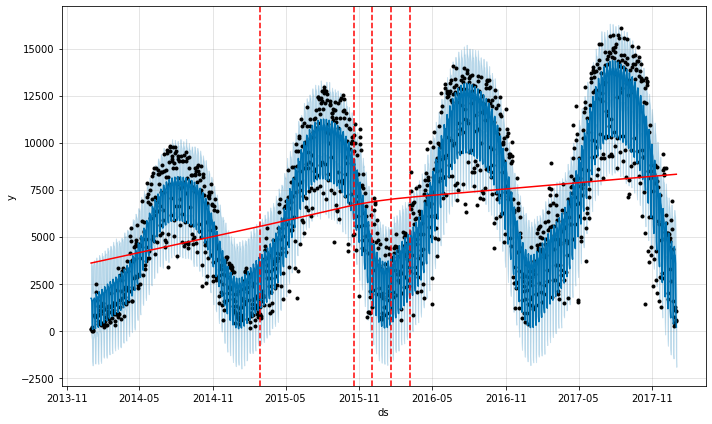

In [6]:
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast)
plot_plotly(model, forecast, trend=True, changepoints=True)

# changepoint는 trend의 변화를 의미한다고 보면된다.
# 여기서 2015년 12월 시점을 보면 trend의 기울기가 조금 변경된 것을 확인할 수 있다.
# 하지만, 이 플롯에서는 모든 changepoint를 표시하진 않고, 중요한 몇개만 표시한다. 따라서 모든 changepoint를 보려면 다른 코드를 써야한다.

In [53]:
model.params['beta']


array([[-0.28855761, -0.56729925,  0.0283838 , -0.03482851,  0.0471962 ,
        -0.0451034 ,  0.00650353, -0.00561545, -0.19349631,  0.13971102,
         0.13561396,  0.00935035, -0.02026224, -0.02152523]])

In [52]:
model.params

{'beta': array([[-0.28855761, -0.56729925,  0.0283838 , -0.03482851,  0.0471962 ,
         -0.0451034 ,  0.00650353, -0.00561545, -0.19349631,  0.13971102,
          0.13561396,  0.00935035, -0.02026224, -0.02152523]]),
 'delta': array([[-6.80598139e-08, -4.07802987e-08, -3.87616359e-08,
         -6.14254863e-03, -1.49851989e-08, -7.77562608e-09,
          3.32923340e-07,  3.48169660e-07,  2.77856376e-02,
          1.17257391e-07,  1.53990866e-07, -4.33911330e-08,
         -5.18705711e-03, -9.52778668e-02, -8.68189406e-02,
         -5.60180478e-02, -3.39913071e-02, -4.62595330e-09,
         -1.11355235e-06, -4.83772637e-08, -4.29852468e-08,
         -4.55749633e-08,  5.32563788e-09, -2.60731418e-08,
         -2.28944904e-09]]),
 'k': array([[0.42240798]]),
 'm': array([[0.2236079]]),
 'sigma_obs': array([[0.09372304]]),
 'trend': array([[0.2236079 , 0.22389722, 0.22418654, ..., 0.51679671, 0.51691093,
         0.51702514]])}

In [33]:
plot_components_plotly(model, forecast)

In [25]:
model_cv=cross_validation(model, horizon='365 days')
model_cv

INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-12-31 00:00:00 and 2016-12-31 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-01-01,-69.521030,-1963.440295,1628.079890,1365,2016-12-31
1,2017-01-02,2973.724584,1448.304101,4819.024599,1772,2016-12-31
2,2017-01-03,3656.886875,1956.867229,5326.598909,4431,2016-12-31
3,2017-01-04,3306.371563,1368.334440,5109.438806,3187,2016-12-31
4,2017-01-05,3238.007527,1571.381439,4990.543866,2833,2016-12-31
...,...,...,...,...,...,...
360,2017-12-27,3624.514703,1778.058422,5438.251183,1117,2016-12-31
361,2017-12-28,3528.637000,1791.067860,5239.494852,1267,2016-12-31
362,2017-12-29,3130.812308,1519.375584,4754.971554,1049,2016-12-31
363,2017-12-30,305.490442,-1466.622821,2036.143201,519,2016-12-31


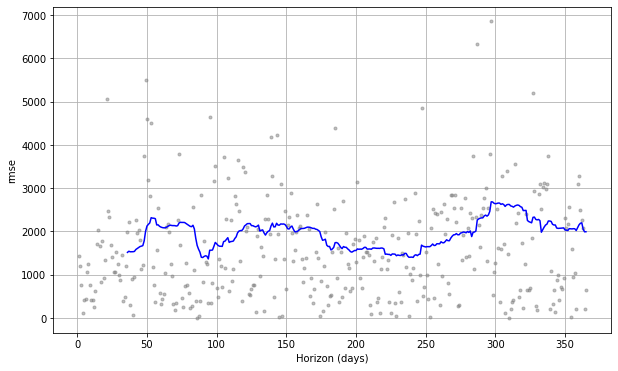

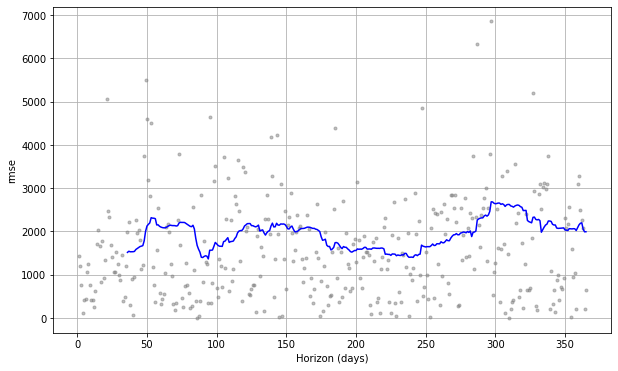

In [31]:
plot_cross_validation_metric(model_cv, metric = 'rmse')

In [29]:
performance_metrics(model_cv)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days,2.302481e+06,1517.392729,1243.010036,0.455121,0.280499,0.833333
1,37 days,2.381994e+06,1543.370830,1264.778277,0.436578,0.280499,0.805556
2,38 days,2.344311e+06,1531.114210,1239.616694,0.419529,0.263005,0.805556
3,39 days,2.349786e+06,1532.901044,1242.901963,0.419758,0.263005,0.805556
4,40 days,2.349511e+06,1532.811399,1241.419369,0.419173,0.263005,0.805556
...,...,...,...,...,...,...,...
325,361 days,4.795807e+06,2189.933026,1770.930819,0.971063,0.341724,0.500000
326,362 days,4.843616e+06,2200.821648,1782.580585,1.010063,0.341724,0.500000
327,363 days,4.210642e+06,2051.984901,1695.748069,0.952085,0.341724,0.500000
328,364 days,3.970588e+06,1992.633338,1619.804885,0.936634,0.341724,0.527778


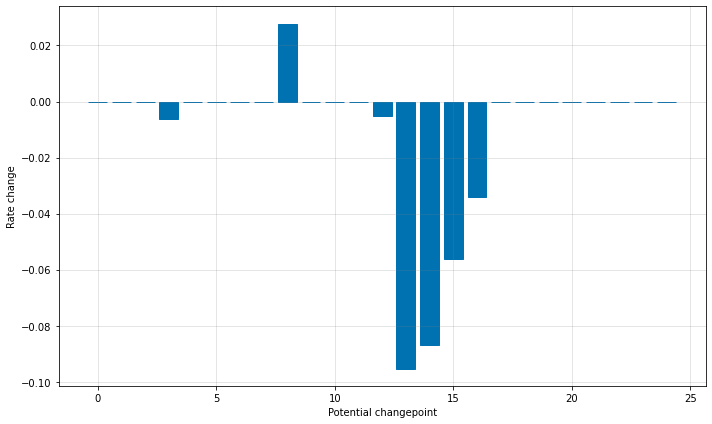

In [46]:
deltas = model.params['delta'].mean(0)
fig = plt.figure(facecolor='w', figsize=(10, 6))
#add_changepoints_to_plot(fig.gca(), model, forecast)

ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas, facecolor='#0072B2', edgecolor='#0072B2')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



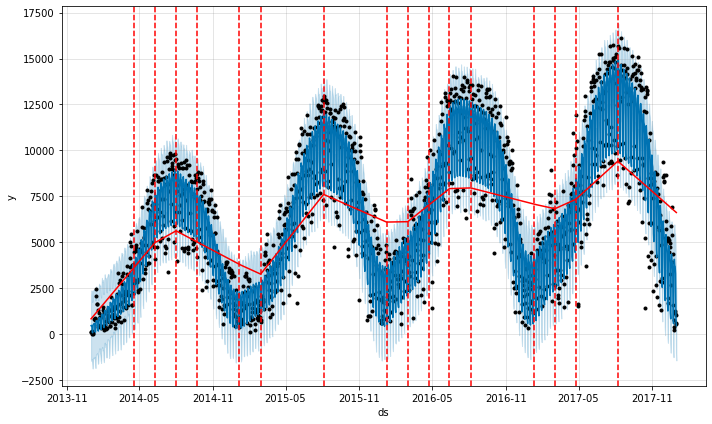

In [89]:
model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=4
                ,changepoint_range=0.9, changepoint_prior_scale=0.7)
model.fit(df)
forecast2 = model.predict()
forecast2.yhat_lower['floor']=0
fig = model.plot(forecast2)
add_changepoints_to_plot(fig.gca(), model, forecast2)
plot_plotly(model, forecast2, trend=True, changepoints=True)
# 이를 보면 위와 다르게 changepoint를 좀더 반영하고, trend의 변화도 더 생긴 것을 알 수 있다.
# 또한, forecast2의 하한선을 0으로 설정하였음. (yhat의 최소치를 0으로 설정하는 것임)
# 자전거 이용자 수가 음수일 수는 없기 때문임.

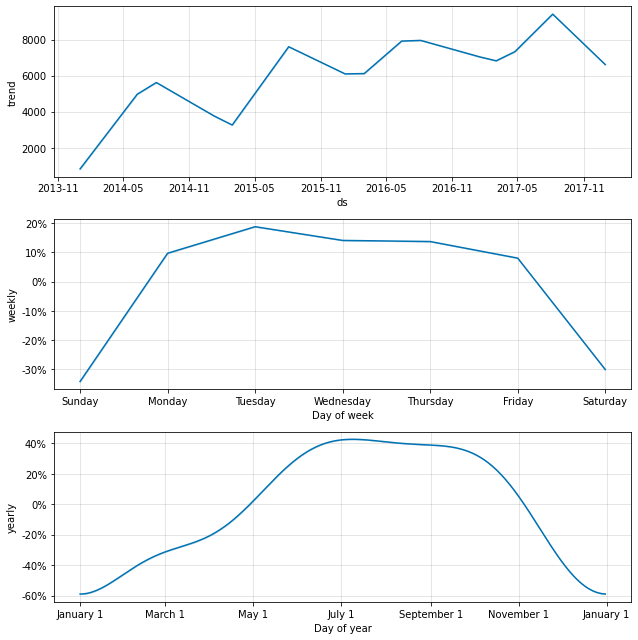

In [69]:
fig = model.plot_components(forecast2)

In [20]:
model_cv2=cross_validation(model, horizon='365 days')
model_cv2

INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-12-31 00:00:00 and 2016-12-31 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-01-01,-69.521030,-1883.741874,1580.312567,1365,2016-12-31
1,2017-01-02,2973.724584,1232.958452,4721.246283,1772,2016-12-31
2,2017-01-03,3656.886875,1812.092769,5382.122685,4431,2016-12-31
3,2017-01-04,3306.371563,1592.690449,4979.578124,3187,2016-12-31
4,2017-01-05,3238.007527,1544.205395,4844.331670,2833,2016-12-31
...,...,...,...,...,...,...
360,2017-12-27,3624.514703,1783.290365,5269.025876,1117,2016-12-31
361,2017-12-28,3528.637000,1699.958076,5256.354625,1267,2016-12-31
362,2017-12-29,3130.812308,1484.930654,4970.671099,1049,2016-12-31
363,2017-12-30,305.490442,-1479.129774,1989.807803,519,2016-12-31


In [21]:
performance_metrics(model_cv2)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days,2.302481e+06,1517.392729,1243.010036,0.455121,0.280499,0.861111
1,37 days,2.381994e+06,1543.370830,1264.778277,0.436578,0.280499,0.833333
2,38 days,2.344311e+06,1531.114210,1239.616694,0.419529,0.263005,0.833333
3,39 days,2.349786e+06,1532.901044,1242.901963,0.419758,0.263005,0.833333
4,40 days,2.349511e+06,1532.811399,1241.419369,0.419173,0.263005,0.833333
...,...,...,...,...,...,...,...
325,361 days,4.795807e+06,2189.933026,1770.930819,0.971063,0.341724,0.500000
326,362 days,4.843616e+06,2200.821648,1782.580585,1.010063,0.341724,0.500000
327,363 days,4.210642e+06,2051.984901,1695.748069,0.952085,0.341724,0.500000
328,364 days,3.970588e+06,1992.633338,1619.804885,0.936634,0.341724,0.527778
